## Time2Vector

## References
- Time2Vec: Learning a Vector Representation of Time  
https://arxiv.org/pdf/1907.05321.pdf

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
class Time2Vector(Layer):
    
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        
        self.seq_len = int(seq_len)
        
    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(self.seq_len,),
                                              initializer='uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(self.seq_len,),
                                           initializer='uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(self.seq_len,),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(self.seq_len,),
                                             initializer='uniform',
                                             trainable=True)
    
    def call(self, x):
        x = tf.math.reduce_mean(x, axis=-1) # Convert (batch, seq_len, features) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
        
        return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)

## Test

In [56]:
# sample data noiseを付与したsin波
def sin(s, T=100):
    return np.sin(2.0*np.pi*s/T)

def test_data(T=100, n=0.05):
    s = np.arange(0,2*T+1)
    noise = n*np.random.uniform(low=-1.0,high=1.0,size=len(s))
    
    return sin(s)+noise

In [57]:
T = 100
f = test_data(T=T,n=0.2).astype(np.float32)

len_seq = len(f)

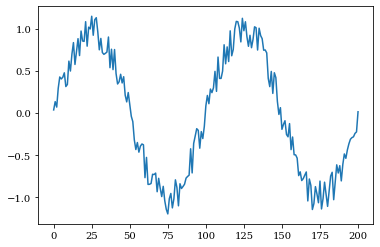

In [58]:
plt.plot(f);

In [59]:
# datasetの作成
max_seq = 25

X = []
y = []

for i in range(len_seq -max_seq):
    X.append(f[i:i+max_seq])
    y.append(f[i+max_seq])
    
X = np.array(X).reshape(-1,max_seq,1)
y = np.array(y).reshape(-1,1)

In [60]:
print('X.shape:',X.shape)
print('y.shape:',y.shape)

X.shape: (176, 25, 1)
y.shape: (176, 1)


In [61]:
# train,valid split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, shuffle=False)

In [62]:
def model_lstm(num_len=max_seq,features=1):
    
    t2v = Time2Vector(num_len)
    
    inp = Input(shape=(num_len,features))
    x = t2v(inp)
    x = LSTM(64,activation='tanh')(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                 )

    return model

In [63]:
model = model_lstm(num_len=max_seq,features=1)

es = EarlyStopping(monitor='val_loss',
                  patience=5,
                  verbose=1)

hist = model.fit(X_train,
                y_train,
                epochs=100,
                batch_size=32,
                validation_data=(X_valid,y_valid),
                callbacks=[es])

Epoch 1/100
5/5 [==============================] - 1s 125ms/step - loss: 0.4868 - val_loss: 0.6566
Epoch 2/100
5/5 [==============================] - 0s 30ms/step - loss: 0.4799 - val_loss: 0.6554
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 0.4757 - val_loss: 0.6788
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 0.4671 - val_loss: 0.6954
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 0.4553 - val_loss: 0.7107
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 0.4218 - val_loss: 0.5313
Epoch 7/100
5/5 [==============================] - 0s 37ms/step - loss: 0.3567 - val_loss: 0.2553
Epoch 8/100
5/5 [==============================] - 0s 36ms/step - loss: 0.2811 - val_loss: 0.1149
Epoch 9/100
5/5 [==============================] - 0s 30ms/step - loss: 0.2207 - val_loss: 0.0865
Epoch 10/100
5/5 [==============================] - 0s 30ms/step - loss: 0.1381 - val_loss: 0.0289
Epoch 11/100
5/5 [

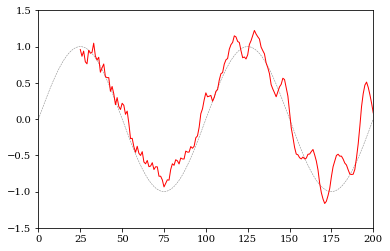

In [64]:
# modelの評価
sin = test_data(T=T,n=0)
gen = [None for i in range(max_seq)]

z = X[:1]

# predction
for i in range(len_seq-max_seq):
    preds = model.predict(z[-1:])
    z = np.append(z,preds)[1:]
    
    z = z.reshape(-1,max_seq,1)
    gen.append(preds[0,0])

fig = plt.figure()
plt.rc('font',family='serif')
plt.xlim([0,2*T])
plt.ylim([-1.5,1.5])

plt.plot(range(len(f)),sin,color='gray',linestyle='--',linewidth=0.5)
plt.plot(range(len(f)),gen,color='red',linewidth=1,);

